# Quantised SqueezeNet

### Imports

In [1]:
import math
import builtins
import numpy as np
import torch
import torch.nn as nn
import torch.jit as jit
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

# Workaround for "RuntimeError: Set changed size during iteration"?
import tqdm
tqdm.monitor_interval = 0

import itertools

# Remember to:
!export PYTHONPATH=$(readlink -m ./pytorch-playground):$PYTHONPATH
from utee import misc, quant, selector
from imagenet import squeezenet
from collections import OrderedDict

### Setup GPU and load the original model
Make sure the ImageNet data is downloaded and converted as detailed [here](./README.md/#imagenet-dataset)

In [2]:
gpu = misc.auto_select_gpu(utility_bound=0, num_gpu=1, selected_gpus='0')
ngpu = len(gpu)
input_size = 224

batch_size = 100
data_root='/tmp/public_dataset/pytorch/'

assert torch.cuda.is_available(), 'no cuda'
torch.manual_seed(117)
torch.cuda.manual_seed(117)

# load model and dataset fetcher
model_orig, ds_fetcher, is_imagenet = selector.select('squeezenet_v1', model_root='~/.torch/models')

Setting GPU: ['0']
Building and initializing squeezenet_v1 parameters


### Evaluate the original model with float32

In [3]:
# Eval model (this is the accuracy at fp32)
val_ds = ds_fetcher(batch_size, data_root=data_root, train=False, input_size=input_size)
acc1, acc5 = misc.eval_model(model_orig, val_ds, ngpu=ngpu, is_imagenet=is_imagenet)
print(f'Original model accuracy: ({acc1}, {acc5})')

Loading pickle object from /tmp/public_dataset/pytorch/imagenet-data/val224.pkl


Building IMAGENET data loader: 50,000 for train; 50,000 for test


=> Done (5.9125 s)


HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

Original model accuracy: (0.55948, 0.7913)


## Infrastructure for changing models

In [4]:
from copy import deepcopy
from inspect import getfullargspec
def model_apply(model, fn, clone=True):
    """
    Recursively map a Module.
    """
    def _apply(m, path):
        if len(getfullargspec(fn).args) > 1:
            um = fn(m, path or '/')
        else:
            um = fn(m)
            
        if um is not None:
            return um
        else:
            for (k, v) in list(m._modules.items()):
                m._modules[k] = _apply(v, f'{path}/{k}')
            return m
    return _apply(deepcopy(model) if clone else model, '')

### Split convolutions into conv+add, and TODO fold batchnorm

In [5]:
class AddBias(nn.Module):
    def __init__(self, num_features):
        super(AddBias, self).__init__()
        self.num_features = num_features
        self.bias = nn.Parameter(torch.Tensor(num_features))
        
    def forward(self, x):
        return x + self.bias.view([1, self.num_features, 1, 1])
    
def split_conv(m):
    if isinstance(m, nn.Conv2d):
        conv = nn.Conv2d(m.in_channels, m.out_channels, m.kernel_size,
                         stride=m.stride, padding=m.padding,
                         dilation=m.dilation, groups=m.groups, bias=False)
        conv.weight = m.weight
        addbias = AddBias(m.out_channels)
        addbias.bias = m.bias
        return nn.Sequential(OrderedDict([('conv', conv), ('addbias', addbias)]))
model_raw = model_apply(model_orig, split_conv)
print(f'Conv2d split into Conv2d + AddBias')

Conv2d split into Conv2d + AddBias


# Collect activation statistics

### Function for inserting loggers

In [6]:
# TODO is this better done with register_forward_hook?
class Logger(nn.Module):
    def __init__(self, name):
        super(Logger, self).__init__()
        #print(f'Creating logger for "{name}"')
        self.name = name
        self.log_items = np.zeros((0, 2))
        
    def forward(self, x):
        # (~4.9it/s)
        # NOTE this takes the min/max of the entire batch (100 images) 
        log_item = [ torch.min(x).data.cpu().numpy()[0],
                     torch.max(x).data.cpu().numpy()[0] ]
        self.log_items = np.append(self.log_items, log_item)                
        return x
    
def duplicate_model_with_logging(model):
    loggers = {}
    def insert_logger(m, path):
        if isinstance(m, (nn.Conv2d, AddBias, nn.Linear, nn.BatchNorm1d, nn.BatchNorm2d, nn.AvgPool2d)):
            log_in  = Logger(f'{path}/log_in')
            log_out = Logger(f'{path}/log_out')
            loggers[log_in.name]  = log_in
            loggers[log_out.name] = log_out
            return nn.Sequential(log_in, m, log_out)
    loggers['input'] = Logger('input')
    r = nn.Sequential(loggers['input'],
                      model_apply(model, insert_logger))
    return r, loggers

### Create copy of model with logging, and collect stats over the test set

In [7]:
# Insert loggers
model_log, loggers = duplicate_model_with_logging(model_raw)
# Run over the test set to collect stats
val_ds = ds_fetcher(batch_size, data_root=data_root, train=False, input_size=input_size)
# Only collect stats from part of the dataset
n_batch = int(val_ds.n_batch * 0.1)
print(f'Only using {val_ds.n_batch} for stats-collection')

# Collect stats
acc1s, acc5s = misc.eval_model(model_log, val_ds, ngpu=ngpu, is_imagenet=is_imagenet, n_sample=n_batch)
print(f'Test accuracy of ({acc1s},{acc5s}), a drop of ({acc1-acc1s},{acc5-acc5s})')
if (acc1 - acc1s) != 0 or (acc5 - acc5s) != 0:
    print("ERROR: transforms have changed accuracy")

Loading pickle object from /tmp/public_dataset/pytorch/imagenet-data/val224.pkl


Building IMAGENET data loader: 50,000 for train; 50,000 for test


=> Done (5.9254 s)


Only using 500 for stats-collection


HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration




Test accuracy of (0.5762,0.7934), a drop of (-0.016720000000000068,-0.0020999999999999908)
ERROR: transforms have changed accuracy


### Get scale factors from the collected stats

In [8]:
# We now have statistics for all the activations. Reduce to a scale factor for each one.
def scale_factor_from_range(min, max, max_q_level=(2**7-1)):
    pos_range = builtins.max(abs(min), abs(max))
    # val = q_val * scale_factor; so:
    scale_factor = pos_range / max_q_level
    return float(scale_factor)
def scale_factor_from_stats(ranges, max_q_level=(2**7-1)):
    min_min = np.min(ranges[0])
    max_max = np.max(ranges[1])
    return scale_factor_from_range(min_min, max_max, max_q_level)
scale_factors = { k : scale_factor_from_stats(np.asarray(v.log_items))
                  for (k,v) in loggers.items() }
scale_factors

{'/classifier/1/addbias/log_in': 2.1596730149637056,
 '/classifier/1/addbias/log_out': 2.1598191148652806,
 '/classifier/1/conv/log_in': 4.711094653512549,
 '/classifier/1/conv/log_out': 2.1596730149637056,
 '/classifier/3/log_in': 2.1598191148652806,
 '/classifier/3/log_out': 0.34802837822380966,
 '/features/0/addbias/log_in': 0.14483134953055796,
 '/features/0/addbias/log_out': 0.14690978883758304,
 '/features/0/conv/log_in': 0.020787402400820273,
 '/features/0/conv/log_out': 0.14483134953055796,
 '/features/10/group1/squeeze/addbias/log_in': 6.9815669022207185,
 '/features/10/group1/squeeze/addbias/log_out': 6.981395811546506,
 '/features/10/group1/squeeze/conv/log_in': 3.7115569828063486,
 '/features/10/group1/squeeze/conv/log_out': 6.9815669022207185,
 '/features/10/group2/expand1x1/addbias/log_in': 3.638255201925443,
 '/features/10/group2/expand1x1/addbias/log_out': 3.6382376603254185,
 '/features/10/group2/expand1x1/conv/log_in': 6.981395811546506,
 '/features/10/group2/expand1x

### Visualise scale factors

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


<IPython.core.display.Javascript object>


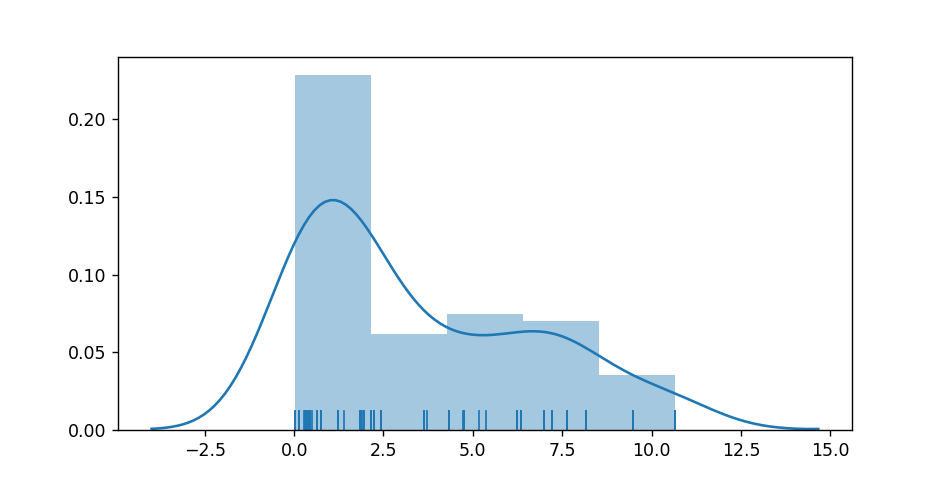

In [9]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sbs
sbs.distplot(list(scale_factors.values()), hist=True, rug=True)

#np.percentile(data, q=[0, 1, 5, 95, 99, 100], axis=0)

# Modifying for quantised inference

### Functions to quantise a model

In [10]:
model_orig

SqueezeNet(
  (features): Sequential(
    (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (3): Fire(
      (group1): Sequential(
        (squeeze): Conv2d (64, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace)
      )
      (group2): Sequential(
        (expand1x1): Conv2d (16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace)
      )
      (group3): Sequential(
        (expand3x3): Conv2d (16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (expand3x3_activation): ReLU(inplace)
      )
    )
    (4): Fire(
      (group1): Sequential(
        (squeeze): Conv2d (128, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace)
      )
      (group2): Sequential(
        (expand1x1): Conv2d (16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace)
  

In [11]:
def quantise(x, scale_factor, saturate_at=None):
    # Quantise the activation
    x = x.div(scale_factor)
    x.round_()
    #x = x.int()
    # Optionally saturate into fixed bit-width
    if saturate_at is not None:
        x = x.clamp(-saturate_at, saturate_at)
    return x
def quantise_const(x, scale_factor, max_q_level):
    if scale_factor is None:
        min = x.min().data.cpu().numpy()[0]
        max = x.max().data.cpu().numpy()[0]
        scale_factor = scale_factor_from_range(min, max, max_q_level)
    x.data = quantise(x.data, scale_factor, saturate_at=max_q_level)
    return scale_factor
def dequantise(x, scale_factor):
    #x = x.float()
    x = x.mul(scale_factor)
    return x

class Quantise(nn.Module):
    def __init__(self, scale_factor, saturate_at=None):
        super(Quantise, self).__init__()
        self.scale_factor = scale_factor
        self.saturate_at = saturate_at
        
    def forward(self, x):
        x = quantise(x, self.scale_factor, self.saturate_at)
        return x

class Saturate(nn.Module):
    def __init__(self, saturate_at):
        super(Saturate, self).__init__()
        self.saturate_at = saturate_at
        
    def forward(self, x):
        x = x.clamp(-self.saturate_at, self.saturate_at)
        return x

class Dequantise(nn.Module):
    def __init__(self, scale_factor):
        super(Dequantise, self).__init__()
        self.scale_factor = scale_factor
        
    def forward(self, x):
        x = dequantise(x, self.scale_factor)
        return x
    
# This just locks values to quantization levels after these ops.
# Also need to:
#  - Quantise weights + biases
#  - Merge Conv2d and BatchNorm weights before quantising (no BatchNorm in this SqN)
#  - Requantize after convolutions to lower bitwidth
#  - 
def duplicate_model_with_quantisation(model):
    def insert_quantise(m, path):
        # (nn.Conv2d, nn.Linear, nn.BatchNorm1d, nn.BatchNorm2d, nn.AvgPool2d)
        if isinstance(m, (nn.Conv2d)):
            sf_conv_in  = scale_factors[f'{path}/conv/log_in']
            sf_conv_out  = scale_factors[f'{path}/conv/log_out']
            sf_bias_in = scale_factors[f'{path}/addbias/log_in']
            
            # Quantise Conv2d weights to 8 bits
            bw_conv_in = 8
            sf_weight = quantise_const(m.weight, scale_factor=None, max_q_level=2**(bw_conv_in-1)-1)
            
            # Bit-width after conv
            bw_conv_out = (2*bw_conv_in + 
                           int(math.ceil(math.log2(m.kernel_size[0] *
                                                   m.kernel_size[1] * 
                                                   m.in_channels))))
            
            # Quantise Conv2d biases to any number of bits, but the same sf as the activation
            sf_bias = sf_conv_in * sf_weight
            #if (sf_bias != sf_conv_out):
            #    print(f"WARNING: calculated scaling factor doesn't match that observed:")
            #    print(f"         {sf_bias} != {sf_conv_out}")
            
            if m.bias is not None:
                 # FIXME we don't enforce a bit-width for biases atm
                quantise_const(m.bias, sf_bias, max_q_level=None)
            
            return nn.Sequential(# Quantise input to 8 bits
                                 Quantise(sf_conv_in, saturate_at=2**(bw_conv_in-1)-1),
                                 # Perform conv + bias
                                 m,
                                 # Saturate to emulate fixed bit-width
                                 Saturate(2**(bw_conv_out-1)-1),
                                 # Dequantise
                                 Dequantise(sf_bias))
        elif isinstance(m, (AddBias)):
            print("ERROR: please use split convs for logging, and original model for quantizing")
            exit(1)
    sf_input = scale_factors['input']
    return nn.Sequential(# Quantise the input, then dequantise
                         Quantise(sf_input, saturate_at=2**7-1),
                         Dequantise(sf_input),
                         # The rest of the model (with quantisation)
                         model_apply(model, insert_quantise))

### Quantise the model and evaluate the drop in accuracy

In [12]:
# Quantise model
model_quant = duplicate_model_with_quantisation(model_orig)
# Evaluate accuracy
val_ds = ds_fetcher(batch_size, data_root=data_root, train=False, input_size=input_size)
acc1q, acc5q = misc.eval_model(model_quant, val_ds, ngpu=ngpu, is_imagenet=is_imagenet) #, n_sample=5)
print(f'Test accuracy of ({acc1q},{acc5q}), a drop of ({acc1-acc1q},{acc5-acc5q})')

Loading pickle object from /tmp/public_dataset/pytorch/imagenet-data/val224.pkl


Building IMAGENET data loader: 50,000 for train; 50,000 for test


=> Done (5.9162 s)


HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

Test accuracy of (0.55558,0.78758), a drop of (0.0039000000000000146,0.0037200000000000566)


---------
# Random code & notes:

In [ ]:
val_ds = ds_fetcher(batch_size, data_root=data_root, train=False, input_size=input_size)
(data, target) = next(val_ds)
data = Variable(torch.FloatTensor(data)).cuda()
model_cuda = torch.nn.DataParallel(model_raw.eval(), device_ids=range(ngpu)).cuda()
trace, out = jit.trace(model_cuda, data)

In [ ]:
trace.graph()

In [ ]:
print(trace)

In [ ]:
# We do dumb quantisation; no fine-tuning.

weights_bw    = 8
biases_bw     = 32
activation_bw = 8
overflow_rate = 0.0
n_sample      = 20
quant_method  = "linear"
    
def duplicate_model_with_quant(model, bits, overflow_rate=0.0, counter=10, type='linear'):
    """assume that original model has at least a nn.Sequential"""
    assert type in ['linear', 'minmax', 'log', 'tanh']
    if isinstance(model, nn.Sequential):
        print(f'> Sequential')
        l = OrderedDict()
        for k, v in model._modules.items():
            print(f'Looking at : {k}')
            if isinstance(v, (nn.Conv2d, nn.Linear, nn.BatchNorm1d, nn.BatchNorm2d, nn.AvgPool2d)):
                parameters = list(v.parameters())
                if isinstance(v, nn.Conv2d):
                    print(f"Found Conv2D:")
                    print(f"  weights: [o,i,k,k] {parameters[0].shape}")
                    print(f"  biases : [o] {parameters[1].shape}")
                l[k] = v
                
            else:
                l[k] = duplicate_model_with_quant(v, bits, overflow_rate, counter, type)
        m = nn.Sequential(l)
        return m
    else:
        print(f'> Not Sequential')
        for k, v in model._modules.items():
            model._modules[k] = duplicate_model_with_quant(v, bits, overflow_rate, counter, type)
        return model

model_quant = duplicate_model_with_quant(model_raw, bits=activation_bw, overflow_rate=overflow_rate,
                                               counter=n_sample, type=quant_method)

In [ ]:
# eval model
val_ds = ds_fetcher(batch_size, data_root=data_root, train=False, input_size=input_size)
acc1q, acc5q = misc.eval_model(model_quant, val_ds, ngpu=ngpu, is_imagenet=is_imagenet)

In [ ]:
acc1q, acc5q

# Exporting model
There is the existing ONNX exporter. Either modify that, or manually add functions to each type of Module and call them recursively.

## MobileNet
Search GitHub; there seem to be plenty of implementations. E.g. https://github.com/marvis/pytorch-mobilenet
There are also implementations for v2.

## MobileNet-SSD
Try modifying https://github.com/amdegroot/ssd.pytorch:
  - Use MobileNet feature extractor
  - Use dw convolutions in SSD (SSDLite)

In [ ]:
model_raw.state_dict().keys()